In [1]:
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors       import LinearSegmentedColormap
from skimage.transform       import resize
from plottify                import autosize
from sklearn                 import metrics
from PIL                     import Image
from adjustText              import adjust_text
from scipy.cluster           import hierarchy
import statsmodels.api   as sm
import matplotlib.pyplot as plt
import numpy             as np
import seaborn           as sns
import pandas            as pd
import scanpy            as sc
import matplotlib
import anndata
import random
import fastcluster
import copy
import umap
import h5py
import sys
import os

main_path = '/raid/users/farzaneh/Histomorphological-Phenotype-Learning'
sys.path.append(main_path)
from models.clustering.correlations import *
from models.clustering.data_processing import *
from models.visualization.attention_maps import *
from data_manipulation.data import Data
import warnings
warnings.filterwarnings("ignore")

/home/farzaneh/miniconda3/envs/HPL/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/farzaneh/miniconda3/envs/HPL/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/farzaneh/miniconda3/envs/HPL/lib/python3.8/site-packages/umap/dist

## LUAD vs LUSC HPC Network

In [11]:
# Dataset name for images.
# dataset            = 'TCGAFFPE_LUADLUSC_5x_60pc'
dataset = 'Meso_250_subsampled'


# Clustering folder details.
# meta_folder    = 'lungtype_nn250_clusterfold4'
# meta_field      = 'labels'
# matching_field  = 'slides'
# resolution     = 2.0
# groupby        = 'leiden_%s' % resolution
# fold_number    = 0


############# mesosubtype
# meta_field     = 'os_event_ind'
meta_field = 'Meso_type'
matching_field = 'slides'
resolution     = 2.0
fold_number    = 2
groupby        = 'leiden_%s' % resolution
meta_folder    = 'meso_nn250'
folds_pickle   = '%s/files/pkl_Meso_250_subsampled_he_complete.pkl'%main_path
additional_as_fold = False

# folds_pickle       = '%s/utilities/files/LUADLUSC/lungsubtype_Institutions.pkl' % main_path
# h5_complete_path   = '%s/results/BarlowTwins_3/TCGAFFPE_LUADLUSC_5x_60pc_250K/h224_w224_n3_zdim128_filtered/hdf5_TCGAFFPE_LUADLUSC_5x_60pc_he_complete_lungsubtype_survival_filtered.h5' % main_path
h5_complete_path = '%s/results/BarlowTwins_3/Meso_250_subsampled/h224_w224_n3_zdim128/hdf5_Meso_250_subsampled_he_complete_combined_metadata_filtered.h5'%main_path
h5_additional_path = None

file_name = h5_complete_path.split('/hdf5_')[1].split('.h5')[0] + '_%s__fold%s' % (groupby.replace('.', 'p'), fold_number)

# Setup folder esqueme
main_cluster_path = h5_complete_path.split('hdf5_')[0]
main_cluster_path = os.path.join(main_cluster_path, meta_folder)
figures_path      = os.path.join(main_cluster_path, 'figures')
if not os.path.isdir(figures_path):
    os.makedirs(figures_path)


In [12]:
# Read H5 AnnData file where the clustering was done.
adata_train, h5ad_path = read_h5ad_reference(h5_complete_path, meta_folder, groupby, fold_number)


In [10]:
adata_train

AnnData object with n_obs × n_vars = 200000 × 128
    obs: 'Meso_type', 'case_number', 'hist_subtype', 'indexes', 'labels', 'original_set', 'os_event_data', 'os_event_ind', 'patterns', 'samples', 'slides', 'stage', 'tiles', 'type', 'leiden_2.0'
    uns: 'leiden', 'nn_leiden', 'pca', 'paga', 'leiden_2.0_sizes', 'leiden_2.0_colors', 'umap', 'Meso_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'nn_leiden_connectivities', 'nn_leiden_distances'

In [13]:
done = False
if os.path.isfile(h5ad_path.replace('.h5ad', '_paga.h5ad')):
    done=True
    adata_train = anndata.read_h5ad(h5ad_path.replace('.h5ad', '_paga.h5ad'))
else:
    sc.tl.paga(adata_train, groups=groupby, neighbors_key='nn_leiden')


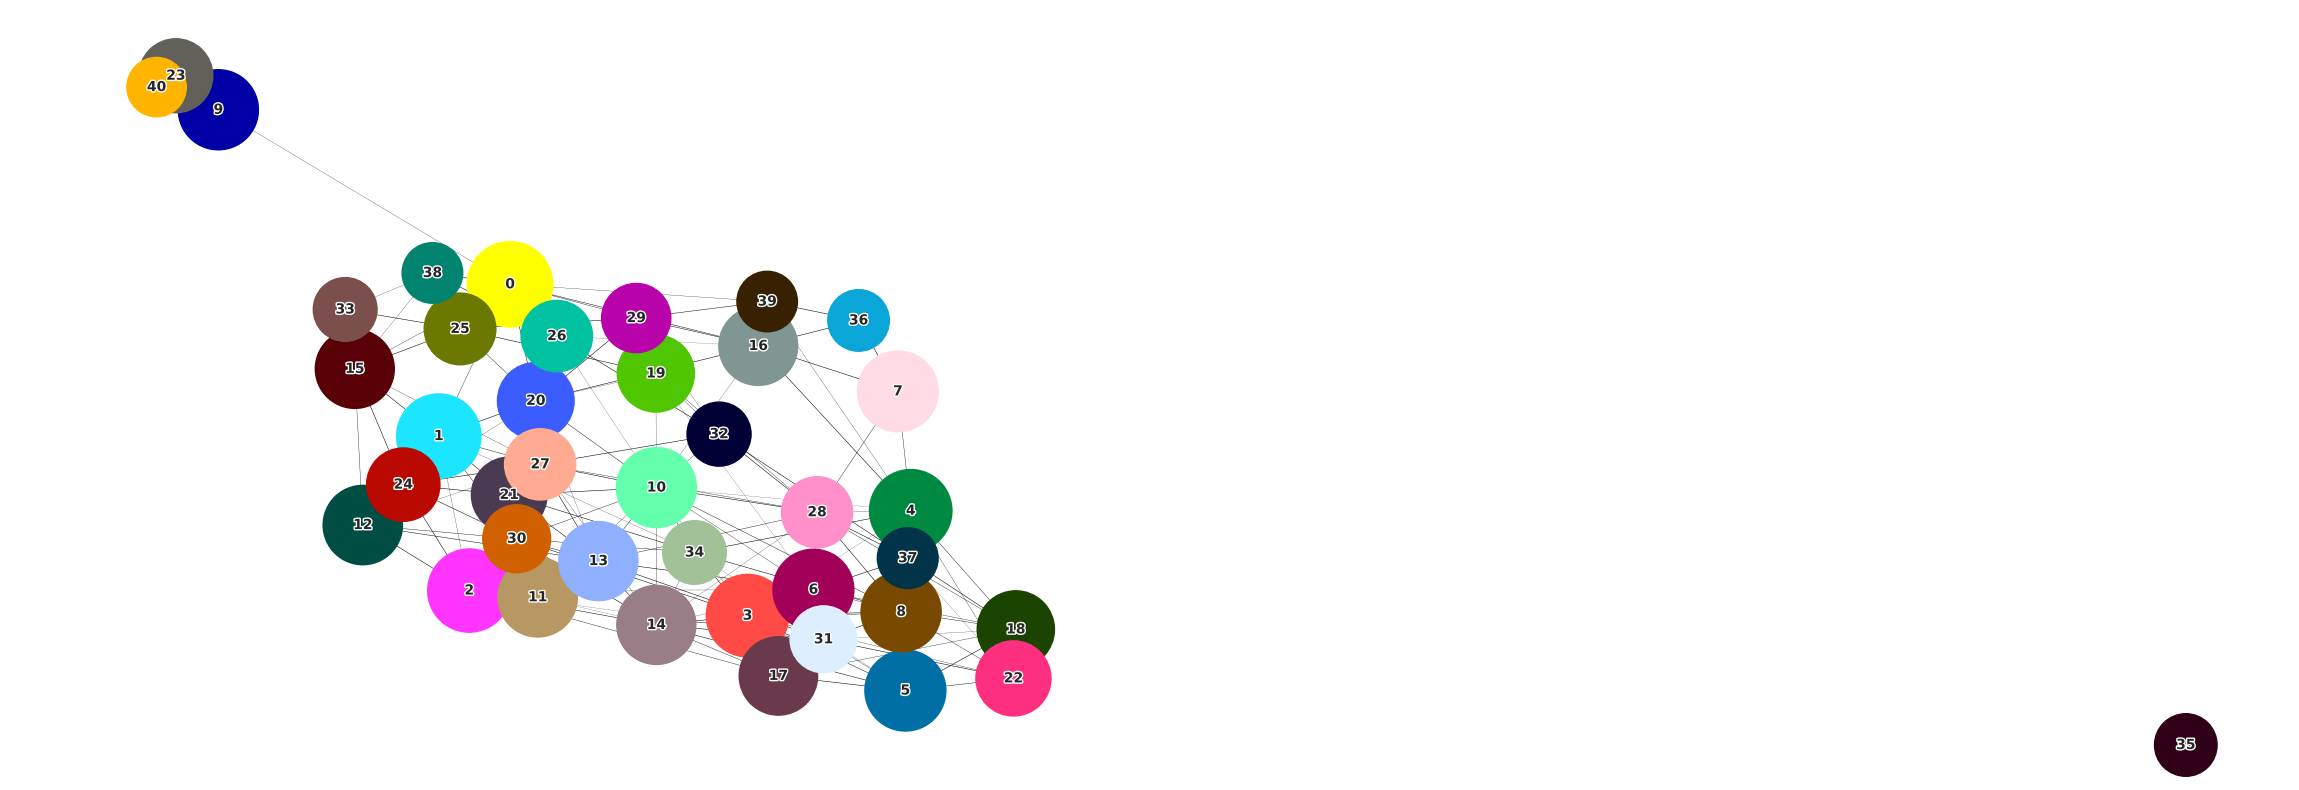

In [14]:
# Graph visualization related
layout           = 'fa'  # ‘fa’, ‘fr’, ‘rt’, ‘rt_circular’, ‘drl’, ‘eq_tree’
random_state     = 0
threshold        = 0.29

# Figure related
node_size_scale  = 25
node_size_power  = 0.5
edge_width_scale = .05
fontsize    = 10
fontoutline = 2
meta_field   = 'Meso_type'

if not done:
    fig = plt.figure(figsize=(100,10))
    ax  = fig.add_subplot(1, 3, 1)
    sc.pl.paga(adata_train, layout=layout, random_state=random_state, color=groupby, threshold=threshold, node_size_scale=node_size_scale, node_size_power=node_size_power,
               edge_width_scale=edge_width_scale, fontsize=fontsize, fontoutline=fontoutline, frameon=False, show=False, ax=ax)
    plt.show()


In [15]:
# Run UMAP based on PAGA cluster visualization.
if not done:
    sc.tl.umap(adata_train, init_pos="paga", neighbors_key='nn_leiden')
    adata_train.write(h5ad_path.replace('.h5ad', '_paga.h5ad'))
    

Meso_type


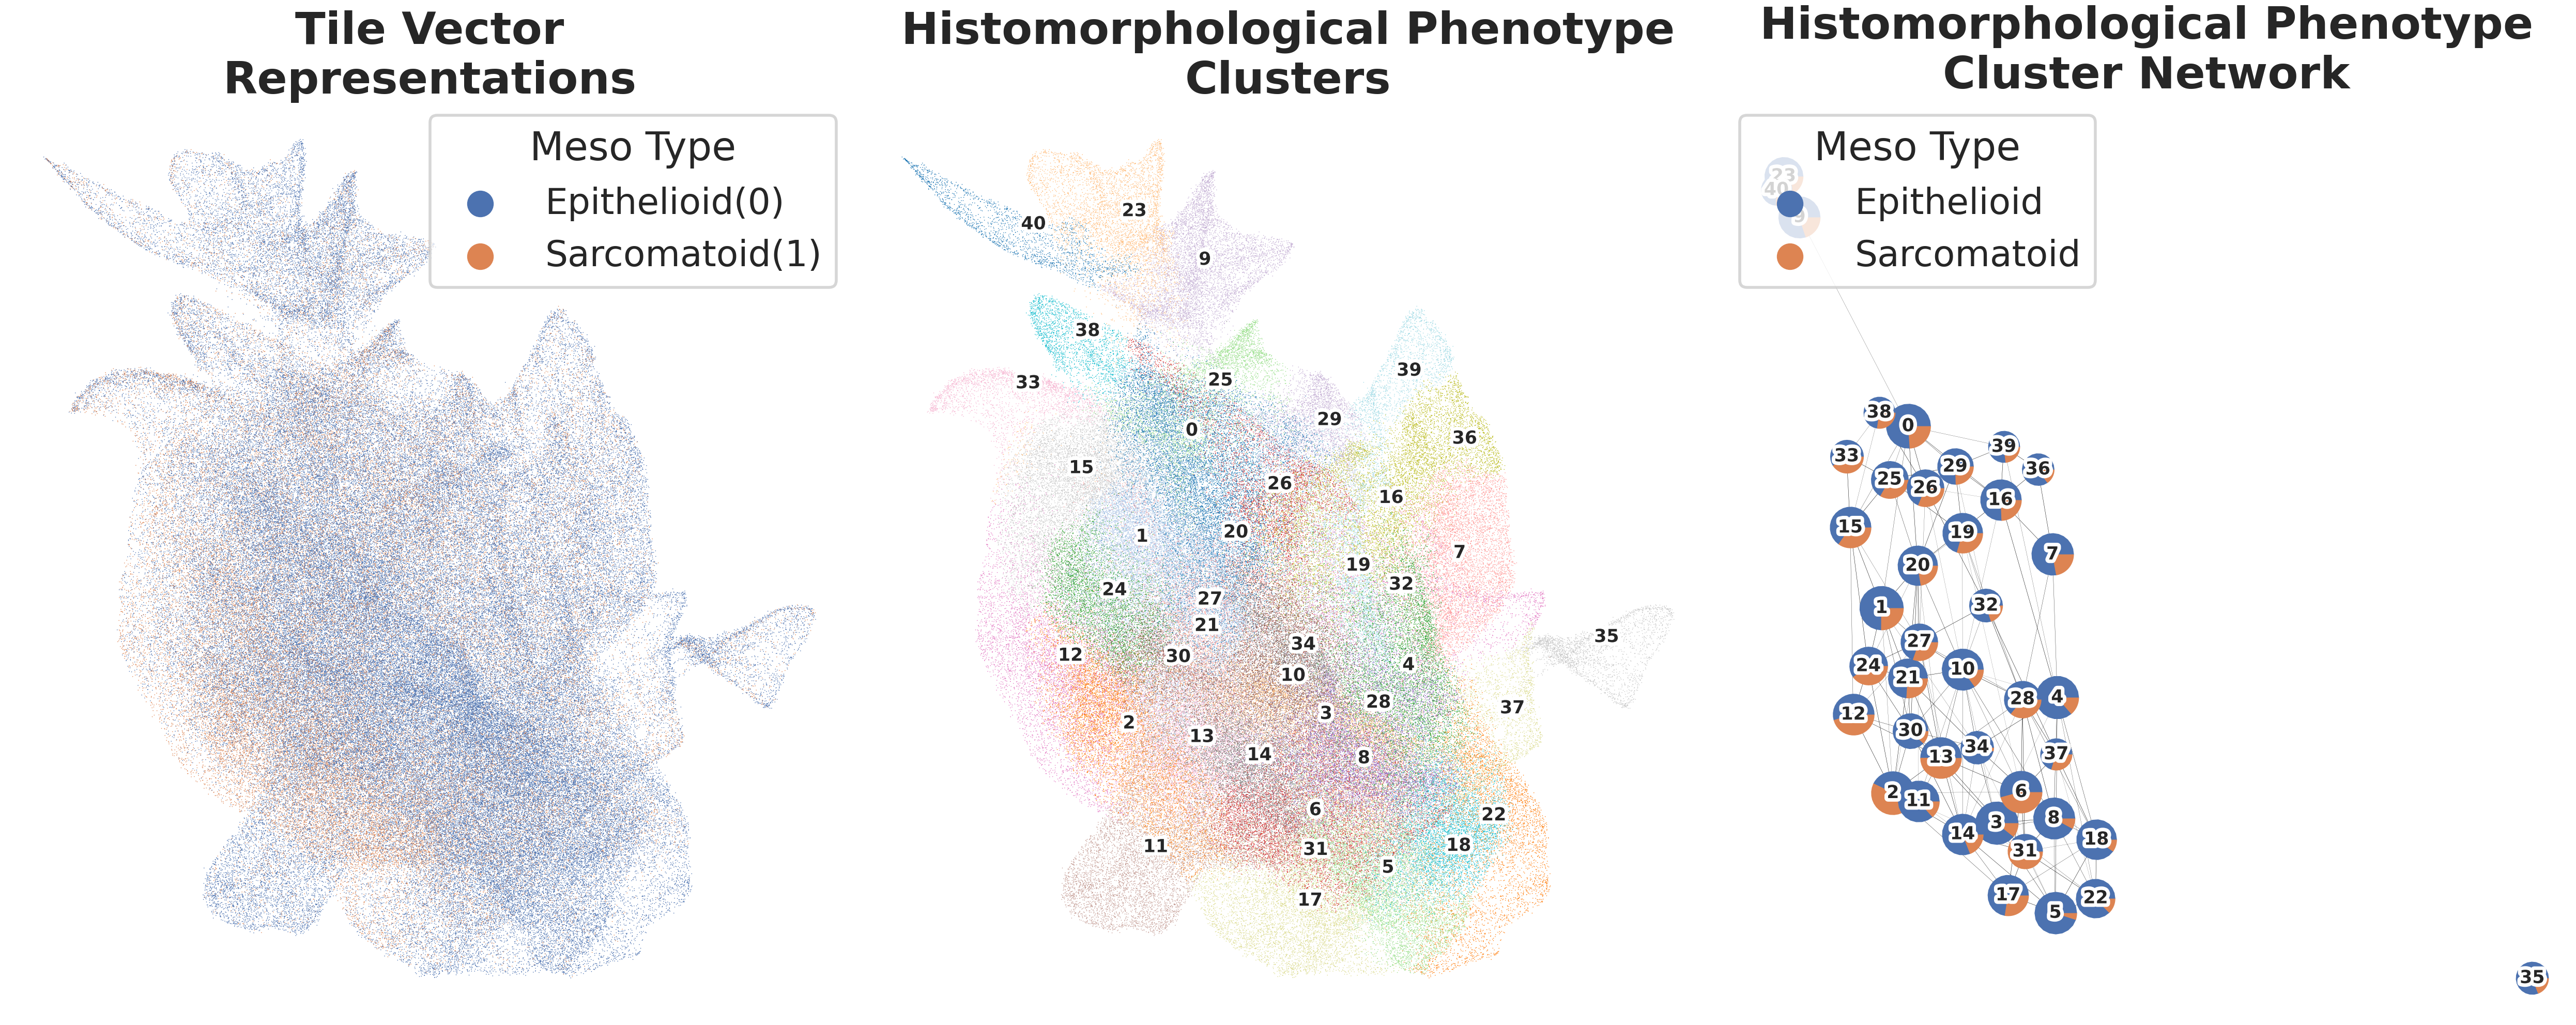

In [16]:
# Representations and Cluster Network.
def show_umap_leiden(adata, meta_field, layout, random_state, threshold, node_size_scale, node_size_power, edge_width_scale, directory, file_name,
                     fontsize=10, fontoutline=2, marker_size=2, ax_size=16, l_size=12, l_t_size=14, l_box_w=1, l_markerscale=1, palette='tab20', figsize=(30,10),
                     leiden_name=False):
    from matplotlib.lines import Line2D

    leiden_clusters = np.unique(adata.obs[groupby].astype(int))
    colors = sns.color_palette(palette, len(leiden_clusters))

    fig = plt.figure(figsize=figsize)
    ax  = fig.add_subplot(1, 3, 1)
    print(meta_field)

    ax = sc.pl.umap(adata, ax=ax, color=meta_field, size=marker_size, show=False, frameon=False, na_color='black')
    if meta_field == 'Meso_type':
        legend_c = ax.legend(loc='best', markerscale=l_markerscale, title='Meso Type', prop={'size': l_size})
        legend_c.get_title().set_fontsize(l_t_size)
        legend_c.get_frame().set_linewidth(l_box_w)
        legend_c.get_texts()[0].set_text('Epithelioid(0)')
        legend_c.get_texts()[1].set_text('Sarcomatoid(1)')
    ax.set_title('Tile Vector\nRepresentations', fontsize=ax_size, fontweight='bold')

    ax  = fig.add_subplot(1, 3, 2)
    sc.pl.umap(adata, ax=ax, color=groupby, size=marker_size, show=False, legend_loc='on data', legend_fontsize=fontsize, legend_fontoutline=fontoutline, frameon=False, palette=colors)
    if leiden_name:
        ax.set_title('Leiden Clusters', fontsize=ax_size, fontweight='bold')
    else:
        ax.set_title('Histomorphological Phenotype\nClusters', fontsize=ax_size, fontweight='bold')

    adjust_text(ax.texts)

    ax  = fig.add_subplot(1, 3, 3)
#     names_lines  = ['LUSC', 'LUAD']
    names_lines = ['Epithelioid', 'Sarcomatoid']
    sc.pl.paga(adata, layout=layout, random_state=random_state, color=meta_field, threshold=threshold, node_size_scale=node_size_scale, node_size_power=node_size_power, edge_width_scale=edge_width_scale, fontsize=fontsize, fontoutline=fontoutline, frameon=False, show=False, ax=ax)
    if meta_field == 'Meso_type':
        legend = ax.legend(legend_c.legendHandles, names_lines, title='Meso Type', loc='upper left', prop={'size': l_size})
        legend.get_title().set_fontsize(l_t_size)
        legend.get_frame().set_linewidth(l_box_w)
    if leiden_name:
        ax.set_title('Leiden Cluster Network', fontsize=ax_size, fontweight='bold')
    else:
        ax.set_title('Histomorphological Phenotype\nCluster Network', fontsize=ax_size, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(directory,file_name))
    plt.show()


sns.set_theme(style='white')
show_umap_leiden(adata_train, meta_field, layout, random_state, threshold, node_size_scale, node_size_power, edge_width_scale, directory=figures_path,
                 file_name=file_name + '_clusternetwork_all_anno.jpg', fontsize=25, fontoutline=10, marker_size=5, ax_size=62, l_size=50, l_t_size=55, l_box_w=4,
                 l_markerscale=6, palette='tab20', figsize=(50,20))

## LUAD Survival HPC Network

In [ ]:
# Dataset name for images.
# dataset            = 'TCGAFFPE_LUADLUSC_5x_60pc'

# Clustering folder details.
# meta_folder    = 'luad_overall_survival_nn250_clusterfold0'
meta_field      = 'os_even_ind'
matching_field  = 'samples'

resolution     = 2.0
groupby        = 'leiden_%s' % resolution
fold_number    = 0

# folds_pickle       = '%s/utilities/files/LUAD/overall_survival_TCGA_folds.pkl'  % main_path
# h5_complete_path   = '%s/results/BarlowTwins_3/TCGAFFPE_LUADLUSC_5x_60pc_250K/h224_w224_n3_zdim128_filtered/hdf5_TCGAFFPE_LUADLUSC_5x_60pc_he`_complete_lungsubtype_survival_filtered.h5' % main_path
# h5_additional_path = None

file_name = h5_complete_path.split('/hdf5_')[1].split('.h5')[0] + '_%s__fold%s' % (groupby.replace('.', 'p'), fold_number)

# Setup folder esqueme
main_cluster_path = h5_complete_path.split('hdf5_')[0]
main_cluster_path = os.path.join(main_cluster_path, meta_folder)
figures_path      = os.path.join(main_cluster_path, 'figures')
if not os.path.isdir(figures_path):
    os.makedirs(figures_path)

correlation_hovernet = '%s/results/BarlowTwins_3/TCGAFFPE_LUADLUSC_5x_60pc_250K/h224_w224_n3_zdim128_filtered/luad_overall_survival_nn250_clusterfold0/leiden_2p0_fold0/correlations/TCGAFFPE_LUADLUSC_5x_60pc_he_complete_lungsubtype_survival_filtered_leiden_2p0__fold0_luad_overall_survival_nn250_clusterfold0_hovernet_critical_coef.csv' % main_path
hovernet_df = pd.read_csv(correlation_hovernet)
hovernet_df = hovernet_df.rename(columns={'Unnamed: 0':'Cell Type'})
hovernet_df

In [13]:
# Read H5 AnnData file where the clustering was done.
adata_train, h5ad_path = read_h5ad_reference(h5_complete_path, meta_folder, groupby, fold_number)


In [15]:
done = False
if os.path.isfile(h5ad_path.replace('.h5ad', '_paga.h5ad')):
    done=True
    adata_train = anndata.read_h5ad(h5ad_path.replace('.h5ad', '_paga.h5ad'))
else:
    sc.tl.paga(adata_train, groups=groupby, neighbors_key='nn_leiden')


In [16]:
layout           = 'fa'  # ‘fa’, ‘fr’, ‘rt’, ‘rt_circular’, ‘drl’, ‘eq_tree’
random_state     = 0
threshold        = 0.74

# Figure related
node_size_scale  = 7
node_size_power  = 0.5
edge_width_scale = .05
fontsize    = 15
fontoutline = 2
meta_field = 'luad'

if not done:
    fig = plt.figure(figsize=(100,10))
    ax  = fig.add_subplot(1, 3, 1)
    sc.pl.paga(adata_train, layout=layout, random_state=random_state, color=meta_field, threshold=threshold, node_size_scale=node_size_scale, node_size_power=node_size_power,
               edge_width_scale=edge_width_scale, fontsize=fontsize, fontoutline=fontoutline, frameon=False, show=False, ax=ax)
    plt.show()


In [17]:
cap_depletion = False

cell_types = list()
for cell_type in hovernet_df['Cell Type']:
    cell_types.append(cell_type)
    for cluster in np.unique(adata_train.obs[groupby]):
        value = hovernet_df[hovernet_df['Cell Type']==cell_type][cluster].values[0]
        if cap_depletion and value < 0:
            value = 0
        adata_train.obs.at[adata_train.obs[groupby]==str(cluster), cell_type] = value

In [ ]:

cmap = sns.diverging_palette(250, 20, as_cmap=True)

sns.set_theme(style='white')
fig = plt.figure(figsize=(30,10))

ax  = fig.add_subplot(1, 3, 1)
ax.set_title('Cell Neoplastic\nEnrichment', fontweight='bold', fontsize=20)
sc.pl.paga(adata_train, layout=layout, random_state=random_state, threshold=threshold, node_size_scale=node_size_scale, node_size_power=node_size_power,
           edge_width_scale=edge_width_scale, fontsize=fontsize, fontoutline=fontoutline, frameon=False, show=False, ax=ax, color='cell neoplastic', cmap=cmap, colorbar=False)


ax  = fig.add_subplot(1, 3, 2)
ax.set_title('Cell Inflammatory\nEnrichment', fontweight='bold', fontsize=20)
sc.pl.paga(adata_train, layout=layout, random_state=random_state, threshold=threshold, node_size_scale=node_size_scale, node_size_power=node_size_power,
           edge_width_scale=edge_width_scale, fontsize=fontsize, fontoutline=fontoutline, frameon=False, show=False, ax=ax, color='cell inflammatory', cmap=cmap, colorbar=False)

ax  = fig.add_subplot(1, 3, 3)
ax.set_title('Cell Dead\nEnrichment', fontweight='bold', fontsize=20)
sc.pl.paga(adata_train, layout=layout, random_state=random_state, threshold=threshold, node_size_scale=node_size_scale, node_size_power=node_size_power,
           edge_width_scale=edge_width_scale, fontsize=fontsize, fontoutline=fontoutline, frameon=False, show=False, ax=ax, color='cell dead', cmap=cmap, colorbar=False)

plt.show()